In [40]:
import gzip
# from BCBio.GFF import GFFExaminer
from pprint import pprint
from imp import reload
import pandas


import pygbrowse

In [9]:
examiner = GFFExaminer()

gff_handle = gzip.open(gff3_fname)

pprint(examiner.available_limits(gff_handle))

## Download GFF3 file

## Just plot gene models

In [4]:
import pandas

In [37]:
%%time
gff3_fname = '/home/dskola/glass_home/model_data/reference_genomes/mm10/Mus_musculus.GRCm38.84.chr.gff3.gz'
assert gzip.open(gff3_fname).readline().decode().strip() == '##gff-version   3', 'First line does not indicate a GFF3 file. Currently only GFF3 annotations are supported.'
gff_data = pandas.read_csv(gff3_fname,
                           sep='\t',
                           comment='#', 
                           header=None, 
                           names=['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'],
                           dtype={'seqid':str, 'source':str, 'type':str, 'start':int, 'end':int, 'score':str, 'strand':str, 'phase':str, 'attributes':str})


CPU times: user 5.96 s, sys: 1.12 s, total: 7.09 s
Wall time: 18.5 s


In [38]:
gff_data.dtypes

seqid         object
source        object
type          object
start          int64
end            int64
score         object
strand        object
phase         object
attributes    object
dtype: object

In [73]:
reload(pygbrowse)
reload(pygbrowse.plots)

<module 'pygbrowse.plots' from '/home/dskola/workspace/python-genome-browser/pygbrowse/plots.py'>

In [74]:
%time gene_models = pygbrowse.plots.GeneModels(gff3_fname)

2018-Jul-23 09:37:38	Loading gene model information from /home/dskola/glass_home/model_data/reference_genomes/mm10/Mus_musculus.GRCm38.84.chr.gff3.gz. This may take a few minutes ...
CPU times: user 1min 36s, sys: 54.2 s, total: 2min 31s
Wall time: 10min 24s


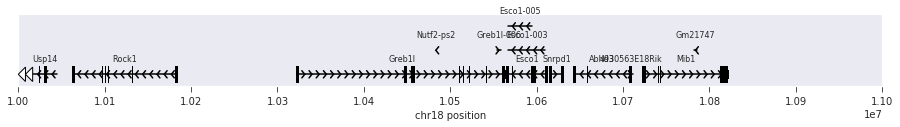

In [205]:
fig = pygbrowse.plots.visualize(plot_objects=[[gene_models]], chrom='chr18', ws=10000000, we=11*1e6)

## Continuous data

## Idea: Leave the tag data on disk and create vectors on the fly. Would need to grab the appropriate chromosome file and then do a binary search to find the correct start point (then iterate until end). We could do something similar for gene models

In [306]:
reload(pygbrowse.datasources)
reload(pygbrowse.utilities)

tag_directory = '/home/dskola/glass_data/mm10/BMDM/RNA/C57_BMDM_polyA_RNA_notx_BC_16_03_08/'
rnaseq_data = pygbrowse.datasources.TagDirectory(tag_directory)

## We can query the data backend

In [307]:
%time res = rnaseq_data.query('chr18', 10009970, 10010000)
print(res)

0 2321354 4642709 42524176
	too high!
0 1160677 2321354 32244793
	too high!
0 580338 1160677 12301499
	too high!
0 290169 580338 10004974
	too low!
290169 435253 580338 11979232
	too high!
290169 362711 435253 10747428
	too high!
290169 326440 362711 10116863
	too high!
290169 308304 326440 10065811
	too high!
290169 299236 308304 10024578
	too high!
290169 294702 299236 10011236
	too high!
290169 292435 294702 10007850
	too low!
292435 293568 294702 10010020
	too high!
292435 293001 293568 10009471
	too low!
293001 293284 293568 10009983
	too high!
293001 293142 293284 10009964
	too low!
293142 293213 293284 10009975
	too high!
293142 293177 293213 10009967
	too low!
293177 293195 293213 10009967
	too low!
293195 293204 293213 10009975
	too high!
293195 293199 293204 10009975
	too high!
293195 293197 293199 10009975
	too high!
293195 293196 293197 10009975
	too high!
final: 293221 	chr18	10009975	1	1.0	24

CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 48.6 ms
10009970    0

## Plot

In [315]:
reload(pygbrowse.plots)

<module 'pygbrowse.plots' from '/home/dskola/workspace/python-genome-browser/pygbrowse/plots.py'>

0 2321354 4642709 42524176
	too high!
0 1160677 2321354 32244793
	too high!
0 580338 1160677 12301499
	too high!
0 290169 580338 10004974
	too high!
0 145084 290169 6226889
	too low!
145084 217626 290169 9313681
	too low!
217626 253897 290169 9848449
	too low!
253897 272033 290169 9993539
	too low!
272033 281101 290169 9996010
	too low!
281101 285635 290169 9997281
	too low!
285635 287902 290169 10001838
	too high!
285635 286768 287902 10000528
	too high!
285635 286201 286768 9997769
	too low!
286201 286484 286768 9999380
	too low!
286484 286626 286768 10000511
	too high!
286484 286555 286626 10000505
	too high!
286484 286519 286555 9999436
	too low!
286519 286537 286555 10000505
	too high!
286519 286528 286537 9999436
	too low!
286528 286532 286537 9999436
	too low!
286532 286534 286537 10000505
	too high!
286532 286533 286534 10000505
	too high!
final: 286557 	chr18	10000505	1	1.0	11



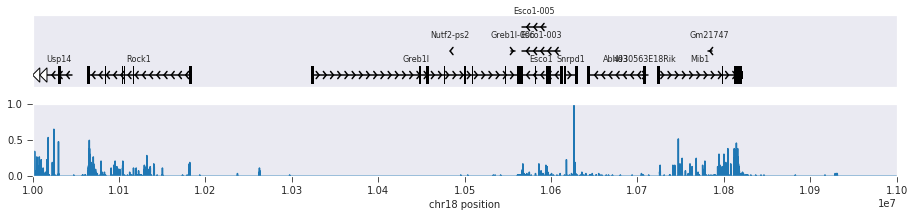

In [317]:
rnaseq_plot = pygbrowse.plots.WigPlot(rnaseq_data, label='RNA-seq', autoscale=True)
fig = pygbrowse.plots.visualize(plot_objects=[[gene_models], [rnaseq_plot]], chrom='chr18', ws=10000000, we=11*1e6)

Do we scale vectors to plot or plot to vectors or allow choice? What's a good interface?? Probably do like other plotting functions. Let users transform their data. But in this case it's a backend object, so we might need to be more proactive.

In [331]:
t[4:6]

slice(4, 6, None)


In [355]:
from pygbrowse.datasources import SeriesDict

In [353]:
class _ChromWrapper:
    def __init__(self, chrom, parent_data_source):
        self.chrom = chrom
        self.parent_data_source = parent_data_source
    
    def __getitem__(self, key):
        print(key)
        # ToDo: Add support for step argument
        try:
            query_start = key.start
            query_end = key.stop
        except TypeError: # Handle scalar indices            
            query_start = key
            query_end = key + 1
            
        return self.parent_data_source.query(chrom=self.chrom, start=query_start, end=query_end)

class _DataVector:
    def __init__(self, chrom, parent_data_source):
        self.loc = _ChromWrapper(chrom=chrom, parent_data_source=parent_data_source)

class _DataSource:
    def __init__(self, data, transform=None, smoothing_bandwidth=0):
        self.transform = transform
        self.smoothing_bandwidth = smoothing_bandwidth
        self.data = {chrom:DataVector(chrom=chrom, parent_data_source=self) for chrom in data}  
        
    def query(self, chrom, start, end)
        result = 
    
    def __getitem__(self, key):
        return self.data[key]

test_data = {'chr1':pandas.Series(numpy.arange(100))}    
ds = DataSource()

In [344]:
class SliceTester:
    def __getitem__(self, key):
        return key
st = SliceTester()

s = st[4:8]

In [351]:
x = 4

In [352]:
x[4:8]

TypeError: 'int' object is not subscriptable

In [328]:
y = pandas.Series()
y.__getitem__()

In [288]:
reload(pygbrowse.utilities)
%time res = pygbrowse.utilities.binary_search_tag_file(tag_filename, 29862292)
print(res)
print()
with open(tag_filename, 'rt') as tag_file:
    tag_file.seek(res)
    print(tag_file.readline())

0 2321354 4642709 42524176
	too high!
0 1160677 2321354 32244793
	too high!
0 580338 1160677 12301499
	too low!
580338 870507 1160677 24506012
	too low!
870507 1015592 1160677 31583726
	too high!
870507 943049 1015592 24683119
	too low!
943049 979320 1015592 30267981
	too high!
943049 961184 979320 25151229
	too low!
961184 970252 979320 25464373
	too low!
970252 974786 979320 28187473
	too low!
974786 977053 979320 28189012
	too low!
977053 978186 979320 29639032
	too low!
978186 978753 979320 30267710
	too high!
978186 978469 978753 30267345
	too high!
978186 978327 978469 30267178
	too high!
978186 978256 978327 30107677
	too high!
978186 978221 978256 29862291
	too low!
978221 978238 978256 30107677
	too high!
978221 978229 978238 29862291
	too low!
978229 978233 978238 30107677
	too high!
978229 978231 978233 29862291
	too low!
978231 978232 978233 29862291
	too low!
final: 978258 	chr18	30107677	0	1.0	50

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 34.6 ms
978258

	

In [236]:
tag_filename = os.path.join(tag_directory, 'chr18.tags.tsv')
with open(tag_filename, 'rt') as tag_file:
    tag_file.seek(286532 + 1)
    print(tag_file.readline())

	chr18	9999436	1	1.0	50



In [177]:
reload(pygbrowse.utilities )
from pygbrowse.utilities import *

In [266]:
with open(tag_filename, 'rt') as tag_file:
    tag_file.seek(0)
    print(tag_file.readline())

	chr18	3004907	1	1.0	48



In [204]:
# import pygbrowse.datasources
# reload(pygbrowse.datasources)
from pygbrowse import datasources
reload(datasources)

<module 'pygbrowse.datasources' from '/home/dskola/workspace/python-genome-browser/pygbrowse/datasources.py'>

In [196]:
class WigPlot(_BrowserSubPlot):
    def __init__(self, data, label=None, color=None, center=False, scale=False, ylim=None,
                 convolution_kernel=None):
        super(WigPlot, self).__init__()
        self.data = data
        self.color = color
        self.vector = vector_series
        self.center = center
        self.scale = scale
        self.label = label
        self.convolution_kernel = convolution_kernel
        self.ylim = ylim
        self.normalization_factor = 1
        
    def plot(self, ax):
        if self.ylim:
            ylim = self.ylim
        else:
            ylim = ax.get_ylim()

        vert_span = (ylim[1] - ylim[0])
        vert_center = vert_span / 2 + ylim[0]

        this_plot_vector = self.data.query(chrom = self.chrom, start = self.ws, end = self.we)

        if self.convolution_kernel is not None:
            this_plot_vector = pandas.Series(
                scipy.signal.convolve(this_plot_vector, self.convolution_kernel, mode='same'),
                index=this_plot_vector.index)

        if self.scale:
            this_plot_vector /= (this_plot_vector.max() - this_plot_vector.min())
            this_plot_vector *= vert_span

        if self.center:
            this_plot_vector -= this_plot_vector.mean()
            this_plot_vector += vert_center
        #         print(self.center, self.scale, vert_center, vert_span, this_plot_vector.min(), this_plot_vector.max())

        this_plot_vector = this_plot_vector.loc[
            (this_plot_vector.index >= self.ws) & (this_plot_vector.index < self.we)]
        ax.plot(this_plot_vector.index, this_plot_vector, color=self.color, label=self.label)
        ax.set_ylim(ylim)
    
    
class TagDirectory(GenomicVectorData):
    tag_strand_translator = {0:'+', 1:'-'}
    def __init__(self, tag_directory_path, normalize_to=DEFAULT_TAG_COUNT_NORMALIZATION_TARGET):
        self.tag_directory_path = tag_directory_path

        if normalize_to:
            # extract total tag count from tagInfo.txt
            tag_info_fname = os.path.join(path_to_tag_folder, 'tagInfo.txt')
            with open(tag_info_fname, 'rt') as tag_info_file:
                sizeline = tag_info_file.readlines()[1].split('\t')
            assert sizeline[0] == 'genome'
            num_tags = int(sizeline[2])

            self.normalization_factor = self.num_tags / normalize_to
        
    def query(self, chrom, start, end, read_handling='starts'):
        # ToDo: Add argument validation to all functions and methods with string parameters
        # ToDo: Add verbosity-based logging output
        # ToDo; Compare performance with memory-mapped pandas DataFrames
        query_result = pandas.Series(numpy.zeros(end-start), index=numpy.arange(start, end))
        
        tag_filename = os.path.join(self.tag_directory_path, '{}.tags.tsv'.format(chrom))
        start_offset = binary_search_tag_file(tag_filename=tag_filename, search_target=start + 1)

        with open(tag_filename, 'rt') as tag_file:
            tag_file.seek(start_offset)
            line_fields = tag_file.readline().strip().split('\t')
            chrom = line_fields[0]
            start = int(line_fields[1]) - 1
            strand = self.tag_strand_translator[int(line_fields[2])]
            depth = float(line_fields[3])            
            
            if read_handling == 'starts':
                query_result.iloc[start] = depth
            elif read_handling == 'reads':
                read_len = int(line_fields[4])
                query_result.iloc[start:start+read_len] = depth
        
        query_result *= self.normalization_factor
        
        return query_result

NameError: name '_BrowserSubPlot' is not defined

In [199]:
x = pandas.Series(numpy.arange(1000,1100), index=numpy.arange(1000,1100))
x.loc[1050:1070]

1050    1050
1051    1051
1052    1052
1053    1053
1054    1054
1055    1055
1056    1056
1057    1057
1058    1058
1059    1059
1060    1060
1061    1061
1062    1062
1063    1063
1064    1064
1065    1065
1066    1066
1067    1067
1068    1068
1069    1069
1070    1070
dtype: int64

In [ ]:

    strand_translator = {'0': 1, '1': -1}

    

    

In [ ]:
## Get total reads (for normalization) from tagInfo file.

In [ ]:
from pgtools import pileups

def load_tag_pileups(data_type, condition, strain, basepath='/home/dskola/projects/coupled_peaks/moremerged/pooled_tag_folders'):
    pileup_folder = '/home/dskola/data/scratch/dskola/pileups/{}_{}_{}'.format(data_type, condition, strain)
    os.makedirs(pileup_folder, exist_ok=True)
    try:
        this_pileup = pileups.Pileups.load(pileup_folder, 'r')
    except (IOError, FileNotFoundError, OSError):
        tag_folder = '/home/dskola/projects/coupled_peaks/moremerged/pooled_tag_folders/pooled_{}_{}_{}/'.format(data_type, condition, strain)
        this_pileup = pileups.StrandedPileups(mm10_genome.contig_lengths, build='mm10')
        this_pileup.load_from_homer_tag_directory(tag_folder)
        this_pileup = this_pileup.mixDown()
        this_pileup.__idiv__(this_pileup.total_reads / 10000000) 
        this_pileup.save(pileup_folder)
        this_pileup = pileups.Pileups.load(pileup_folder, 'r')
    return this_pileup

def generate_vis_from_pileup(pileup, chrom, ws, we):
    return pandas.Series(pileup.pileups[chrom][ws:we], index=numpy.arange(ws,we))

In [ ]:
tag_pileups = {}
for data_type in ('h3k27ac', 'rna', 'pu1', 'ctcf', 'atac'):
    if data_type not in tag_pileups:
        tag_pileups[data_type] = {}
    for condition in ('notx',):
        if condition not in tag_pileups[data_type]:
            tag_pileups[data_type][condition] = {}
        for strain in ('c57', 'balb'):
            if strain not in tag_pileups[data_type][condition]:
                tag_pileups[data_type][condition][strain] = load_tag_pileups(data_type, condition, strain)

In [ ]:
pu1_tags = pygbrowse.plots.WigPlot()